In [11]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.widgets import Slider
from scipy.optimize import minimize, OptimizeResult
%matplotlib widget

#Type hint imports
import numpy.typing as npt
from typing import Callable, Optional
from matplotlib.figure import Figure
from matplotlib.axes import Axes

#Type Aliases
FloatVector = npt.NDArray[np.float64]
FloatArray = npt.NDArray[np.float64]
Oracle = Callable[[FloatVector], float]
OracleGradient = Callable[[FloatVector], FloatVector]

# Quadratic Penalty Method

Let us consider the following optimization problem:

$$ min_{x \in \mathcal{R}^n} f(x) \qquad \text{s.t.} \; c_i(x) = 0 \quad \forall \; i \in \mathcal{E}$$

We can transform this problem into an unconstrained optimization problem by considering a penalized version of the objective function. Indeed, if we penalize values of $x$ that do not respect the constraints, then the minimum should be found in a point that approximately respects the constraint and minimizes $f$. For this reason we define the quadratic penalty function:

$$ Q(x;\mu) := f(x) + \frac{\mu}{2} \sum_{i \in \mathcal{E}}c_i^2(x) $$

where $\mu>0$ is the penalty parameter. By driving $\mu \to \infty$ we penalize the constraint violations with increasing severity. So it makes sense to consider a sequence of penalization values $\mu_k \uparrow \infty$ and find for them a sequence of approximate minimizers $x_k$ of $Q(x;\mu_k)$. Intuitively $x_k$ should converge to the optimum $x^*$ as $k \to \infty$

## Example: Quadratic Penalization Method Over The Unit Circle

As an example we consider the following optimization problem:

$$ \min_{x,y} x+y \qquad \text{s.t.} \; x^2 + y^2 = 1$$

obviously the minimum is found at $(x^*,y^*) = (-\frac{1}{\sqrt{2}},-\frac{1}{\sqrt{2}})$, and indeed we can check that the KKT conditions are satisfied with $\lambda^* = -\frac{1}{\sqrt(2)}$ because:

$$ \nabla_x \mathcal{L}(x^*,y^*,\lambda^*) = (1,1) - (-\frac{1}{\sqrt(2)}) \cdot (-2 \cdot \frac{1}{\sqrt{2}}, - 2 \cdot\frac{1}{\sqrt{2}}) = (0,0)$$

In [12]:
def f(x : FloatVector ) -> float:
    return x[0]+x[1]

def c(x : FloatVector) -> float:
    return x[0]**2 + x[1]**2 - 1

def grad_f(x : FloatVector ) -> FloatVector:
    return np.array([1,1])

def grad_c(x : FloatVector) -> FloatVector:
    return np.array([2*x[0], 2*x[1]])

constraints = [c]
grad_constraints = [grad_c]

We define the quadratic penalty function, and observe its behavior as $\mu$ changes

In [14]:
def quadratic_penalty_function(f : Oracle, constraints : list[Oracle], mu : float) -> Oracle:
    def Q(x : FloatVector) -> float:
        return f(x) + mu/2 * sum([c(x)**2 for c in constraints])
    return Q

def quadratic_penalty_gradient(
    grad_f : OracleGradient, 
    constraints : list[Oracle], 
    grad_constraints : list[OracleGradient],
    mu : float
    ) -> OracleGradient:
    def grad_Q(x : FloatVector) -> FloatVector:
        return grad_f(x) + mu * sum([c(x) * grad_c(x) for c, grad_c in zip(constraints, grad_constraints)])
    return grad_Q

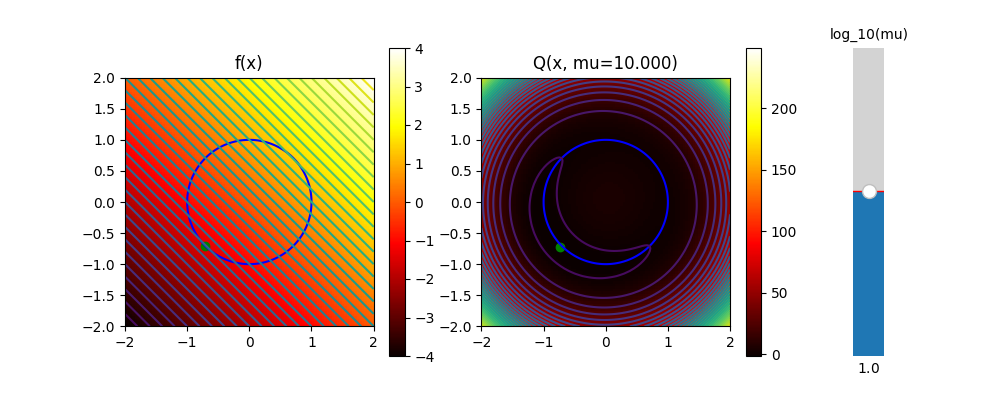

In [15]:
def plot_opt_problem(
    X : FloatArray,
    Y : FloatArray,
    Z : FloatArray,
    C : FloatArray,
    minimum : FloatVector,
    fig : Figure,
    ax : Axes,
    ax_title : Optional[str]= None,
) -> None:
    ax.scatter([minimum[0]], [minimum[1]], color = "green")
    heatmap = ax.imshow(
        Z, 
        extent=(np.amin(X), np.amax(X), np.amin(Y), np.amax(Y)), 
        origin='lower',
        cmap='hot',
        interpolation='nearest')
    if ax_title is not None:
        fig.colorbars.append(fig.colorbar(heatmap))
    ax.contour(X, Y, C, levels=[0], colors='blue')
    ax.contour(X, Y, Z, levels = 40)
    ax.set_title(ax_title)

        
fig,(ax_0, ax_1, ax_2) = plt.subplots(1,3, width_ratios=[0.5,0.5,0.1])
fig.colorbars = []
fig.set_size_inches(w=10, h = 4)

x = np.linspace(-2, 2, 100)
y = np.linspace(-2, 2, 100)
X, Y = np.meshgrid(x, y)
XY = np.array([X,Y])
Z = f(XY)
C = c(XY)
optimum = np.array([-1/np.sqrt(2),-1/np.sqrt(2)])
plot_opt_problem(X=X,Y=Y,Z=Z,C=C, minimum=optimum ,fig=fig,ax=ax_0, ax_title="f(x)")

def plot_penalty_fun(mu_log : float):
    mu = 10**mu_log
    if len(fig.colorbars)>1:
        fig.colorbars[-1].remove()
        del(fig.colorbars[-1])
    ax_1.clear()
    Q_fun = quadratic_penalty_function(f=f, constraints=constraints, mu=mu)
    Q = Q_fun(XY)
    Q_min = minimize(fun=Q_fun, x0=optimum).x
    plot_opt_problem(X=X, Y=Y, Z=Q, C=C, minimum=Q_min, ax_title=f"Q(x, {mu=:.3f})",fig=fig, ax=ax_1)

default_mu = 1
mu_slider = Slider(
    ax=ax_2,
    label="log_10(mu)",
    valmin=-1.3,
    valmax=3,
    valinit=default_mu,
    orientation="vertical"
)
mu_slider.on_changed(plot_penalty_fun)
plot_penalty_fun(mu_log = default_mu)

The two graphs above display the heatmap of the objective function $f(x)$ and $Q(x,\mu)$. The green dot in the first graph represents the minimum of the object inside the feasible set, drawn as a blue circle; while the green dot in the second graph is the minimum of $Q$ subject to no constraints.

By incrasing the value of $\mu$ we can see that the minimum in the second graph approaches the actual optimum of the constrained optimization problem.

### Convergence result of the quadratic penalty method

By playing around with $\mu$ we can observe that our intuitions were correct: by driving $\mu \to \infty$ the minimum of $Q(x,\mu)$ gets closer and closer to the actual solution.

In fact, the following statement can be proven:

Let $\tau_k \downarrow 0^+$ and $\mu_k \uparrow +\infty$ be two sequences and let $x_k$ be such that:
$$ ||\nabla_x Q(x_k, \mu_k)|| \leq \tau_k$$
If $x_k \to x^*$ converges to a feasible point and the constraint gradients $\nabla c_i(x^*)$ are linearly independent, then $x^*$ is a KKT point of the constrained optimization problem with lagrange multipliers:
$$ \lambda_i^* = \lim_{k \to \infty} -\mu_k c_i(x_k)$$

This result justifies the algorithm below for finding an optimal solution to the constrained optimization problem

In [16]:
def quadratic_penalty_method(
    x0 : FloatVector,
    f : Oracle,
    constraints : list[Oracle],
    grad_f : OracleGradient,
    grad_constraints : list[OracleGradient],
    convergenge_tolerance = 1e-9,
    mu_0 = 10,
    r = 5,
) -> tuple[FloatVector, list[OptimizeResult], list[float]]:
    mu = mu_0
    x = x0
    minimizations = []
    mu_list = []
    while True:
        mu_list.append(mu)
        omega = 0.001/mu
        eta = 1/mu**0.1
        Q = quadratic_penalty_function(f=f, constraints=constraints, mu=mu)
        grad_Q = quadratic_penalty_gradient(
            grad_f=grad_f, constraints=constraints, grad_constraints=grad_constraints, mu=mu
            )
        minimization = minimize(fun=Q, jac = grad_Q, x0=x, tol=omega)
        minimizations.append(minimization)
        x = minimization.x
        cx = np.array([c(x) for c in constraints])
        if np.all(np.abs(cx) <= eta):
            if np.all(np.abs(cx) <= convergenge_tolerance):
                return x, minimizations, mu_list
        mu *= r

In [17]:
x, minimizations, mu_list = quadratic_penalty_method(
    x0=np.array([0,0]), f=f, constraints=constraints, grad_f=grad_f, grad_constraints=grad_constraints
)

print(f"Exact optimal solution = {optimum}")
print(f"Exact Lagrangian multiplier = {-1/np.sqrt(2)}")
print(f"total number of function calls = {sum([m.nfev for m in minimizations])}")
print(f"Final penalization mu = {mu_list[-1]}\n")

for i,minimization in enumerate(minimizations):
    print(f"SUB PROBLEM {i+1}: mu = {mu_list[i]}")
    print(f"found x = {minimization.x} using {minimization.nfev} function calls")
    cx = np.array([c(minimization.x) for c in constraints])
    c_grads = np.column_stack([grad_c(minimization.x) for grad_c in grad_constraints])
    lambdas = -mu_list[i] * cx
    print(f"lambda ~= -mu * c(x) = {lambdas}")
    print(f"constraint violation = {np.linalg.norm(cx, ord = np.infty)}")
    print(f"lagrangian gradient = {grad_f(minimization.x) - lambdas*np.sum(c_grads,axis=1)} \n \n")

Exact optimal solution = [-0.70710678 -0.70710678]
Exact Lagrangian multiplier = -0.7071067811865475
total number of function calls = 155
Final penalization mu = 2441406250

SUB PROBLEM 1: mu = 10
found x = [-0.73089309 -0.73089309] using 7 function calls
lambda ~= -mu * c(x) = [-0.68409407]
constraint violation = 0.06840940747295088
lagrangian gradient = [7.40676142e-07 7.40676142e-07] 
 

SUB PROBLEM 2: mu = 50
found x = [-0.71205472 -0.71205472] using 6 function calls
lambda ~= -mu * c(x) = [-0.70219306]
constraint violation = 0.014043861191800122
lagrangian gradient = [2.2890132e-07 2.2890132e-07] 
 

SUB PROBLEM 3: mu = 250
found x = [-0.70810467 -0.70810467] using 6 function calls
lambda ~= -mu * c(x) = [-0.7061103]
constraint violation = 0.0028244412012301545
lagrangian gradient = [7.00791536e-10 7.00791536e-10] 
 

SUB PROBLEM 4: mu = 1250
found x = [-0.7073067 -0.7073067] using 6 function calls
lambda ~= -mu * c(x) = [-0.70690692]
constraint violation = 0.0005655255379832802
l

As we can see the quadratic penalty method converges to the optimal solution. We can also observe that for the last subproblems the number of function calls required for the optimization increases significantly. This is due to the fact that for large values of $\mu$ the Hessian of $Q(\cdot, \mu)$ tends to get more ill conditioned, leading to all kinds of numerical and stability issues that impede convergence.

This can also be observed using the tool above: for large values of $\mu$ the contour plot gets increasingly narrow around the optimal point, an undesirable property for many optimization algorithms.

## Augmented Lagrangian

A big problem with the quadratic penalty method is that to ensure that the solution respects the constraints we need to set $\mu$ to a big value. In turn, this usually makes the Hessian of $Q$ very ill conditioned, leading to all kinds of numerical and convergence problems.

From the convergence result of the quadratic penalty method we know that:
$$ c_i(x) \approx -\lambda_i^* / \mu_k$$
So for $\mu \to \infty$ the constraint is respected. One may ask if we can alter $Q$ so to avoid this systematic perturbation in the constraint value. The augmented Lagrangian achieves this by including an explicit estimate of the Lagrange multipliers $\lambda$ in the objective:

$$ \mathcal{L}_A(x, \lambda; \mu) := f(x) - \sum_i \lambda_i c_i(x) + \frac{\mu}{2}\sum_i c_i(x)^2$$

A theorem proves that if $\lambda$ is chosen to be the exact multiplier, then the optimal solution $x^*$ is a strict minimizer of $\mathcal{L}_A$ for $\mu$ big enough.

Of course, we don't know exactly $\lambda^*$ at the start of the optimization, but from:
$$ 0 \approx \nabla\mathcal{L}_A(x_k, \lambda_k, \mu_k) = \nabla f(x_k) - \sum_i [\lambda_i^k - \mu_k c_i(x_k)]\nabla c_i(x)k $$

we can deduce that:
$$ \lambda_i^* \approx \lambda_i^k - \mu_k c_i(x_k)$$
from which the approximation scheme:
$$ \lambda_i^{k+1} := \lambda_i^k - \mu_k c_i(x_k)$$

All of these ideas are at the core of the method of multipliers, which works like the penalization method but achieves greater stability by incorporating approximate lagrange multipliers into the schema, optimizing at each iteration $\mathcal{L}_A(\cdot , \lambda^k, \mu_k)$.

In [18]:
def augmented_lagrangian(
    f : Oracle, 
    constraints : list[Oracle],
    lambdas : FloatVector,
    mu : float
) -> Oracle:
    def La(x : FloatVector) -> float:
        cx = np.array([c(x) for c in constraints])
        return f(x) - np.sum(lambdas*cx) + mu/2 * np.sum(cx**2, axis = 0)
    return La

def augmented_lagrangian_grad(
    grad_f : OracleGradient,
    constraints : list[Oracle],
    grad_constraints : list[OracleGradient],
    lambdas : FloatVector,
    mu : float
) -> OracleGradient:
    def grad_La(x: FloatVector) -> FloatVector:
        cx = np.array([c(x) for c in constraints])
        c_grads = np.column_stack([c_grad(x) for c_grad in grad_constraints])
        return grad_f(x) + np.sum((mu*cx-lambdas)[:,np.newaxis]*c_grads, axis=1)
    return grad_La 

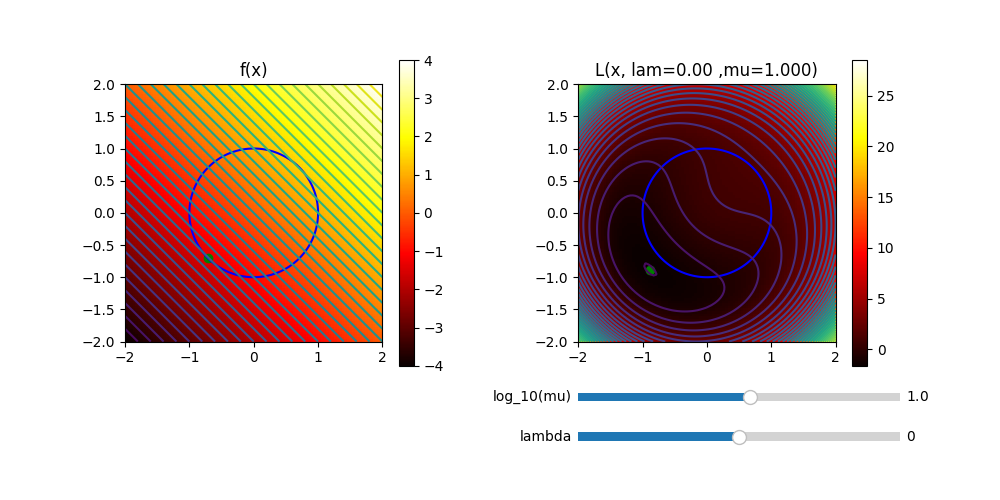

In [10]:

fig = plt.figure()
gridspec = fig.add_gridspec(nrows=3,ncols=3, width_ratios = [0.4,0.05,0.4], height_ratios = [0.9,0.05,0.05])
ax_0 = fig.add_subplot(gridspec[0, 0])
ax_1 = fig.add_subplot(gridspec[0, 2])
ax_2 = fig.add_subplot(gridspec[1,2])
ax_3 = fig.add_subplot(gridspec[2,2])
fig.colorbars = []
fig.set_size_inches(w=10, h = 5)

x = np.linspace(-2, 2, 100)
y = np.linspace(-2, 2, 100)
X, Y = np.meshgrid(x, y)
XY = np.array([X,Y])
Z = f(XY)
C = c(XY)
optimum = np.array([-1/np.sqrt(2),-1/np.sqrt(2)])
plot_opt_problem(X=X,Y=Y,Z=Z,C=C, minimum=optimum ,fig=fig,ax=ax_0, ax_title="f(x)")

def plot_lagrangian(lam: float, mu : float):
    lambdas = np.array([lam])
    if len(fig.colorbars)>1:
        fig.colorbars[-1].remove()
        del(fig.colorbars[-1])
    ax_1.clear()
    L_fun = augmented_lagrangian(f=f, constraints=constraints, lambdas=lambdas, mu=mu)
    L = L_fun(XY)
    L_min = minimize(fun=L_fun, x0=optimum).x
    plot_opt_problem(X=X, Y=Y, Z=L, C=C, minimum=L_min, ax_title=f"L(x, {lam=:.2f} ,{mu=:.3f})",fig=fig, ax=ax_1)

default_mu = 1.0
default_lam = 0.0

def change_mu(log_mu : float):
    global lam
    global mu
    mu = 10**log_mu
    plot_lagrangian(lam=lam, mu=mu)

mu_slider = Slider(
    ax=ax_2,
    label="log_10(mu)",
    valmin=-1.3,
    valmax=3,
    valinit=default_mu,
    orientation="horizontal"
)
mu_slider.on_changed(change_mu)

def change_lam(new_lam : float):
    global lam
    global mu
    lam = new_lam
    plot_lagrangian(lam=lam, mu=mu)

lam_slider = Slider(
    ax=ax_3,
    label="lambda",
    valmin=-2,
    valmax=2,
    valinit=default_lam,
    orientation="horizontal"
)
lam_slider.on_changed(change_lam)

mu = 10**default_mu
lam = default_lam
    

plot_lagrangian(lam = lam, mu = default_mu)

For $\lambda = 0$ we have that $\mathcal{L}_A(x,0,\mu) = Q(x,\mu)$ so $\mathcal{L}_A$ behaves exactly as the penalized function.

However, if we set $\lambda \approx -0.71$ we can see that even for low values of $\mu$ the optimum of the augmented Lagrangian is close to the optimum of the original constrained optimization problem.

Below we implement a simplified version of the method of multipliers and compare its performance to the quadratic penalty method.

In [19]:
def method_of_multipliers(
    x0 : FloatVector,
    f : Oracle,
    constraints : list[Oracle],
    grad_f : OracleGradient,
    grad_constraints : list[OracleGradient],
    convergenge_tolerance = 1e-9,
    mu_0 = 10,
    r = 5,
) -> tuple[FloatVector, list[OptimizeResult]]:
    mu = mu_0
    x = x0
    minimizations = []
    mu_list = []
    lambdas = np.zeros(len(constraints))
    lambda_list = []
    while True:
        mu_list.append(mu)
        lambda_list.append(lambdas)
        omega = 1/mu
        eta = 1/mu**0.1
        L = augmented_lagrangian(f=f, constraints=constraints, lambdas = lambdas, mu=mu)
        grad_L = augmented_lagrangian_grad(
            grad_f=grad_f, constraints=constraints, 
            grad_constraints=grad_constraints, lambdas=lambdas, mu=mu
            )
        # print(L(x), grad_L(x))
        minimization = minimize(fun=L, jac=grad_L, x0=x, tol=omega)
        minimizations.append(minimization)
        x = minimization.x
        cx = np.array([c(x) for c in constraints])
        if np.all(np.abs(cx) <= eta):
            if np.all(np.abs(cx) <= convergenge_tolerance):
                return x, minimizations, mu_list, lambda_list
        lambdas = lambdas - mu * cx
        mu *= r

In [20]:
x, minimizations, mu_list, lambda_list = method_of_multipliers(
    x0=np.array([0,0]), f=f, constraints=constraints, grad_f=grad_f, grad_constraints=grad_constraints
)

print(f"Exact optimal solution = {optimum}")
print(f"Exact Lagrangian multiplier = {-1/np.sqrt(2)}")
print(f"total number of function calls = {sum([m.nfev for m in minimizations])}")
print(f"Final penalization mu = {mu_list[-1]}\n")

for i,minimization in enumerate(minimizations):
    print(f"SUB PROBLEM {i+1}: mu = {mu_list[i]} and lam = {lambda_list[i]}")
    print(f"found x = {minimization.x} using {minimization.nfev} function calls")
    cx = np.array([c(minimization.x) for c in constraints])
    c_grads = np.column_stack([grad_c(minimization.x) for grad_c in grad_constraints])
    print(f"constraint violation = {np.linalg.norm(cx, ord = np.infty)}")
    print(f"lagrangian gradient = {grad_f(minimization.x) - lambdas*np.sum(c_grads,axis=1)} \n \n")

Exact optimal solution = [-0.70710678 -0.70710678]
Exact Lagrangian multiplier = -0.7071067811865475
total number of function calls = 17
Final penalization mu = 1250

SUB PROBLEM 1: mu = 10 and lam = [0.]
found x = [-0.73039593 -0.73039593] using 5 function calls
constraint violation = 0.06695641595876878
lagrangian gradient = [-0.032936 -0.032936] 
 

SUB PROBLEM 2: mu = 50 and lam = [-0.66956416]
found x = [-0.70737486 -0.70737486] using 5 function calls
constraint violation = 0.0007583722316564234
lagrangian gradient = [-0.00037928 -0.00037928] 
 

SUB PROBLEM 3: mu = 250 and lam = [-0.70748277]
found x = [-0.70710624 -0.70710624] using 4 function calls
constraint violation = 1.5179979989676795e-06
lagrangian gradient = [5.92279268e-07 5.92279268e-07] 
 

SUB PROBLEM 4: mu = 1250 and lam = [-0.70710327]
found x = [-0.70710678 -0.70710678] using 3 function calls
constraint violation = 7.241029997828718e-11
lagrangian gradient = [-1.66683941e-07 -1.66683941e-07] 
 



We can observe that the method of multipliers gets a more precise solution with significantly less oracle calls. Thanks to the approximated Lagrangian multiplier, the optimum of each subproblem respects the constraints even with low values of $\mu$, therefore improving the stability and performance of the algorithm.